<a href="https://colab.research.google.com/github/yoavram/MarineML/blob/main/computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📷 Session 3: The AI Field Ecologist
**Objective:** Automate detection and identification of marine animals from images.


**Tools:**
1.  **[MegaDetector](https://megadetector.readthedocs.io/):** A model trained on millions of camera trap images to find "Animals" (bounding boxes).
 - MegaDetector is "dumb"—it only knows "Animal" or "Human". It doesn't know species.
2.  **[BioCLIP](https://imageomics.github.io/bioclip/):** A foundation model that knows the taxonomy of 450,000 species. It looks at the box and says "That's a *Phoca vitulina*".
 - BioCLIP is smart, but slow. We only run it on the small cropped boxes (efficiency).

This code installs the libraries and defines the helper functions.

In [1]:
# @title ⚙️ Setup (Run this once)
print("Installing libraries... (this takes ~1 min)")
!pip install megadetector open_clip_torch matplotlib requests --quiet


Installing libraries... (this takes ~1 min)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 820.5/820.5 kB 27.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.8/414.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [24]:
# @title Import libraries
%matplotlib inline
import torch
import numpy as np
import requests
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from collections import Counter
import open_clip
from megadetector.detection import run_detector
import matplotlib.pyplot as plt

In [3]:
# @title Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Detecting animals using MegaDetector

In [4]:
# @title Load MegaDetector
print("Loading MegaDetector...")
detector = model = run_detector.load_detector('MDV5A')

wandb: W&B disabled due to login timeout.


Loading PT detector with compatibility mode classic
Loaded image size 1280 from model metadata
Using model stride: 64
PTDetector using device cuda:0


INFO:yolov5:Fusing layers... 
Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


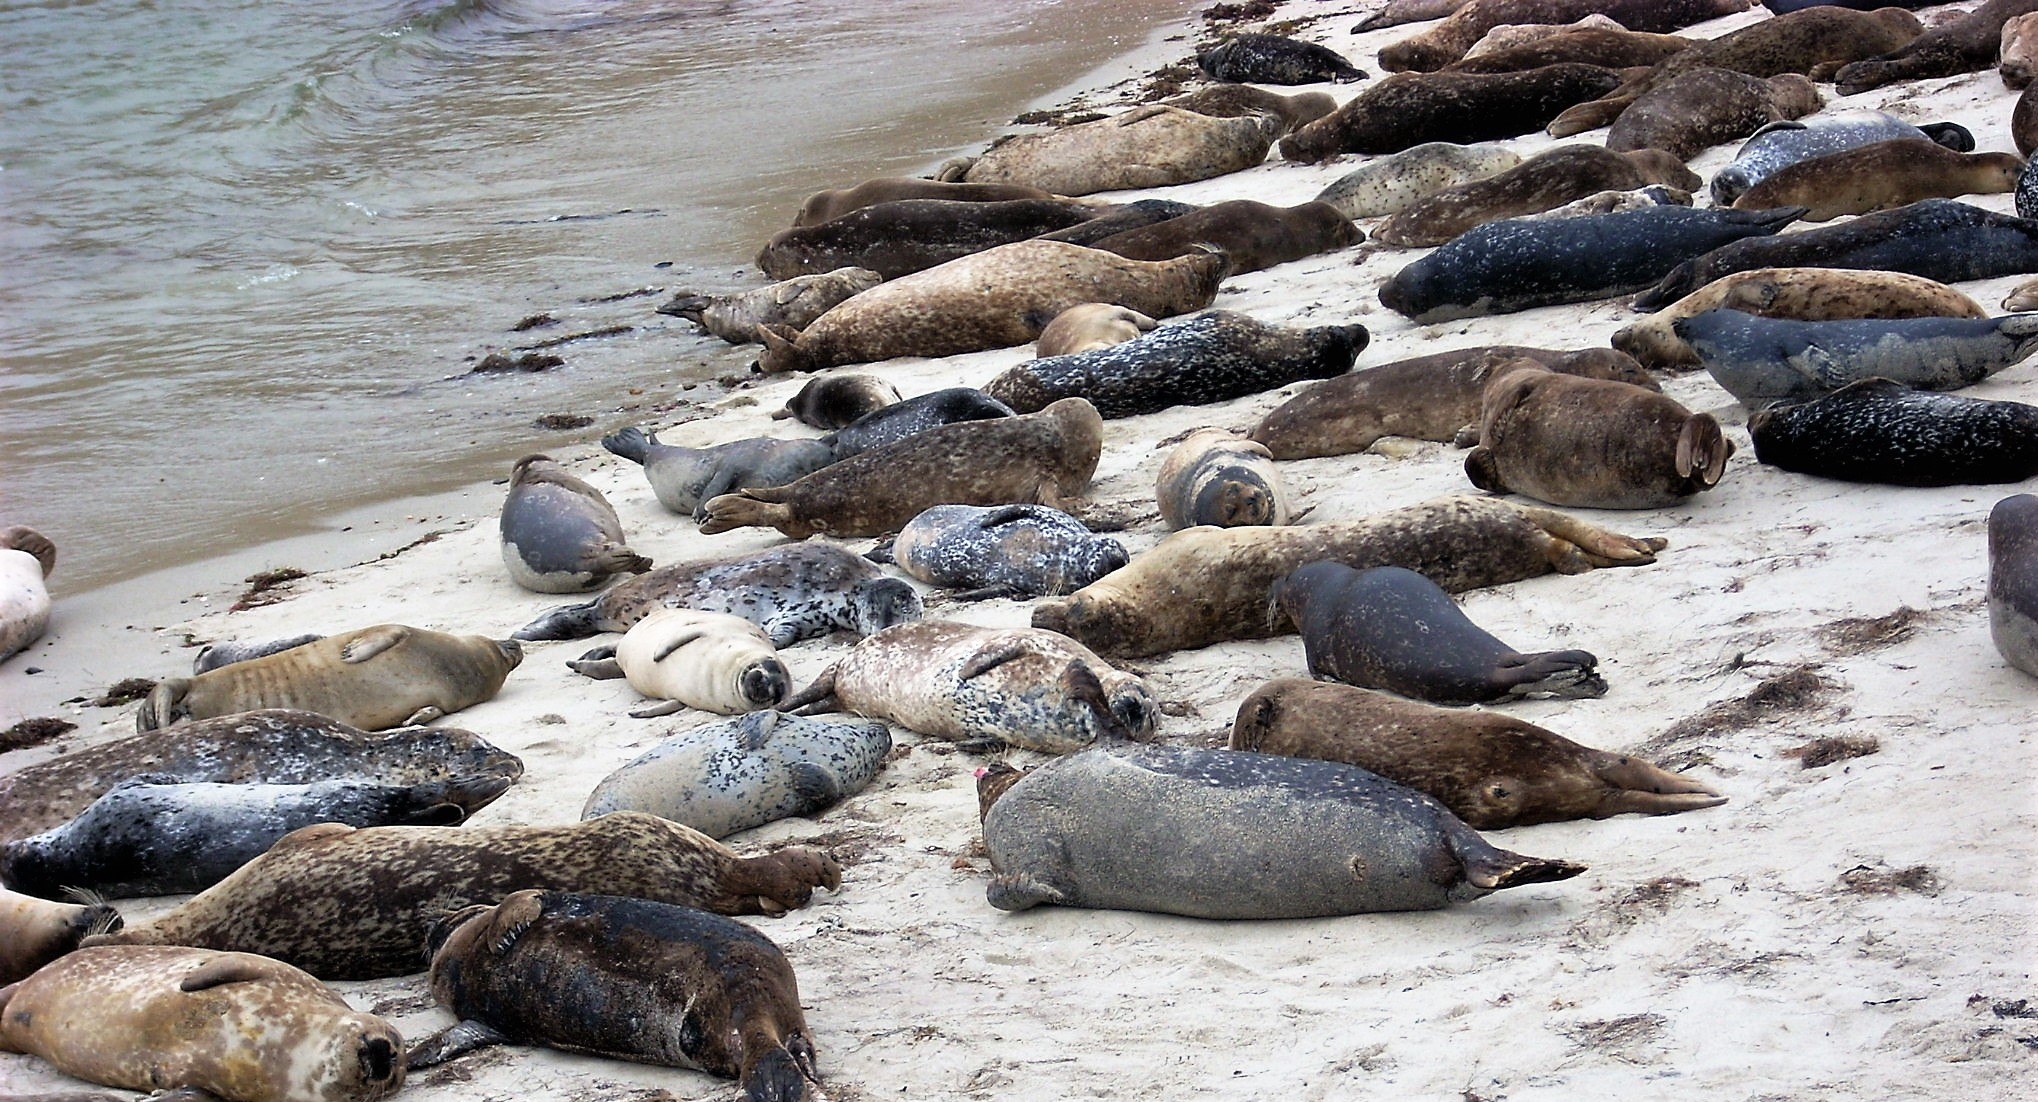

In [32]:
# image_url = "https://upload.wikimedia.org/wikipedia/commons/0/07/Emperor_Penguin_Manchot_empereur.jpg"

# image_url = "https://i.pinimg.com/originals/c1/cc/80/c1cc8019c992aad46e09a43122656eac.jpg"

image_url = 'https://70milesofcoast.com/wp-content/uploads/2021/09/2009-Harbor-Seals.jpg'

# image_url = 'https://70milesofcoast.com/wp-content/uploads/2021/09/Harbor-Seals-Childrens-Pool-3-1536x1152.jpg'

#image_url = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fjourneyz.co%2Fwp-content%2Fuploads%2F2021%2F08%2FMost-Beautiful-Mediterranean-Sea-Animals.jpg&f=1&nofb=1&ipt=4c77470dffc7447fcdae7099012426aeefb8e9504037f173e2440767546dabce'

response = requests.get(image_url, headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
})
assert response.status_code == 200, "Failed to download image"
image = Image.open(BytesIO(response.content)).convert("RGB")
image

In [33]:
# @title Detect with MegaDetector
results = model.generate_detections_one_image(image)
detections = [detect for detect in results['detections'] if detect['conf'] > 0.2]
print(f"🔎 Found {len(detections)} animals.")

🔎 Found 30 animals.


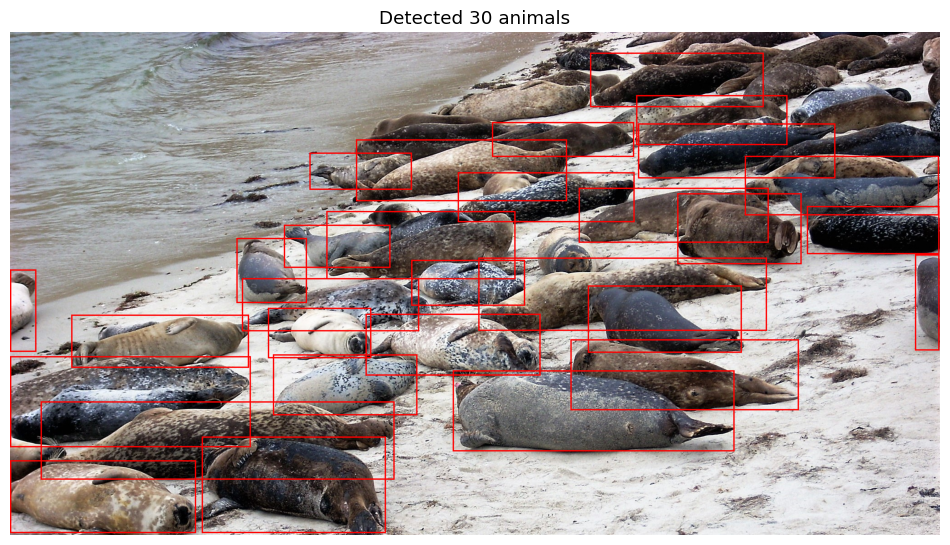

In [34]:
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)
width, height = image.size
for det in detections:
    x1, y1, x2, y2 = det['bbox'] # [x_min, y_min, width_of_box, height_of_box]
    x1, y1 = int(x1*width), int(y1*height)
    x2, y2 = x1 + int(x2*width), y1 + int(y2*height)
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

plt.figure(figsize=(12, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title(f"Detected {len(detections)} animals")
plt.show()

# Species identification with BIOClip
**Goal:** Use a Foundation Model to identify species *without* training it.

**The Concept:**
In the past, we had to train models on our specific data (like the Random Forest).
Today, we use **Foundation Models** like **BioCLIP**, which has already seen 10 million biological images.

**The Challenge:**
The [**Fish4Knowledge**](https://homepages.inf.ed.ac.uk/rbf/Fish4Knowledge/GROUNDTRUTH/RECOG/) dataset contains very blurry, low-res underwater images.
Can BioCLIP identify these fish correctly, even though it has never seen this specific dataset before?

**Critical Tweak:** "Underwater" Prompt Engineering

For zero-shot fish recognition, standard prompts ("A photo of [Species]") fail because the model expects a clean, air-based photo. You must align the text with the visual reality of your crop.

Change your prompts to:
- "A blurry underwater photo of [Species]"
- "A close-up photo of [Species] in the ocean"
- "A noisy image of [Species] fish"


In [2]:
# @title Get the Fish4Knowledge dataset (Real underwater footage)
base_url = "https://homepages.inf.ed.ac.uk/rbf/Fish4Knowledge/GROUNDTRUTH/RECOG/Archive/fish_image/"
extract_dir = "fish_knowledge_data"

# Clean up previous downloads/extractions to ensure a fresh start
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
    print(f"Removed existing {extract_dir} directory")
os.makedirs(extract_dir, exist_ok=True)

In [3]:

print(f"⬇️ Downloading and extracting datasets into {extract_dir}...")
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

for folder_code, _ in list(species_map.items()):
    tar_url = f"{base_url}{folder_code}.tar"
    tar_local_filename = f"{folder_code}.tar"

    print(f"Downloading {tar_local_filename}...")
    response = requests.get(tar_url, stream=True, headers=headers)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

    total_size = int(response.headers.get('content-length', 0))

    with open(tar_local_filename, "wb") as file:
        with tqdm(
            desc=tar_local_filename,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)

    print(f"📦 Extracting {tar_local_filename}...")
    with tarfile.open(tar_local_filename) as tar:
        # Explicitly set filter to 'data' to suppress DeprecationWarning in Python 3.14+
        tar.extractall(extract_dir, filter='data')
    os.remove(tar_local_filename) # Clean up the downloaded tar file

print("✅ Data Ready!")


⬇️ Downloading and extracting datasets into fish_knowledge_data...


fish_01.tar: 100%|██████████| 200M/200M [00:12<00:00, 16.4MiB/s]


📦 Extracting fish_01.tar...


fish_02.tar: 100%|██████████| 35.1M/35.1M [00:02<00:00, 13.6MiB/s]


📦 Extracting fish_02.tar...


fish_03.tar: 100%|██████████| 49.6M/49.6M [00:03<00:00, 16.4MiB/s]


📦 Extracting fish_03.tar...


fish_04.tar: 100%|██████████| 72.2M/72.2M [00:04<00:00, 17.3MiB/s]


📦 Extracting fish_04.tar...


fish_05.tar: 100%|██████████| 53.0M/53.0M [00:03<00:00, 16.5MiB/s]


📦 Extracting fish_05.tar...


fish_06.tar: 100%|██████████| 4.92M/4.92M [00:01<00:00, 4.64MiB/s]


📦 Extracting fish_06.tar...


fish_07.tar: 100%|██████████| 3.60M/3.60M [00:01<00:00, 3.45MiB/s]


📦 Extracting fish_07.tar...


fish_08.tar: 100%|██████████| 4.02M/4.02M [00:01<00:00, 3.76MiB/s]


📦 Extracting fish_08.tar...


fish_09.tar: 100%|██████████| 5.08M/5.08M [00:01<00:00, 4.75MiB/s]


📦 Extracting fish_09.tar...


fish_10.tar: 100%|██████████| 4.94M/4.94M [00:01<00:00, 4.63MiB/s]


📦 Extracting fish_10.tar...


fish_11.tar: 100%|██████████| 2.28M/2.28M [00:00<00:00, 2.44MiB/s]


📦 Extracting fish_11.tar...


fish_12.tar: 100%|██████████| 3.30M/3.30M [00:00<00:00, 3.54MiB/s]


📦 Extracting fish_12.tar...


fish_13.tar: 100%|██████████| 7.13M/7.13M [00:01<00:00, 6.00MiB/s]


📦 Extracting fish_13.tar...


fish_14.tar: 100%|██████████| 1.13M/1.13M [00:00<00:00, 1.42MiB/s]


📦 Extracting fish_14.tar...


fish_15.tar: 100%|██████████| 664k/664k [00:00<00:00, 974kiB/s]


📦 Extracting fish_15.tar...


fish_16.tar: 100%|██████████| 8.57M/8.57M [00:01<00:00, 6.53MiB/s]


📦 Extracting fish_16.tar...


fish_17.tar: 100%|██████████| 613k/613k [00:00<00:00, 899kiB/s]


📦 Extracting fish_17.tar...


fish_18.tar: 100%|██████████| 642k/642k [00:00<00:00, 951kiB/s]


📦 Extracting fish_18.tar...


fish_19.tar: 100%|██████████| 800k/800k [00:00<00:00, 1.18MiB/s]


📦 Extracting fish_19.tar...


fish_20.tar: 100%|██████████| 1.17M/1.17M [00:00<00:00, 1.47MiB/s]


📦 Extracting fish_20.tar...


fish_21.tar: 100%|██████████| 241k/241k [00:00<00:00, 451kiB/s]


📦 Extracting fish_21.tar...


fish_22.tar: 100%|██████████| 876k/876k [00:00<00:00, 1.10MiB/s]


📦 Extracting fish_22.tar...


fish_23.tar: 100%|██████████| 360k/360k [00:00<00:00, 664kiB/s]

📦 Extracting fish_23.tar...
✅ Data Ready!


In [ ]:
# Mapping folder names (fish_01) to Real Scientific Names
species_map = {
    "fish_01": "Dascyllus reticulatus",
    "fish_02": "Plectroglyphidodon dickii",
    "fish_03": "Chromis chrysura",
    "fish_04": "Amphiprion clarkii",
    "fish_05": "Chaetodon lunulatus",
    "fish_06": "Chaetodon trifascialis",
    "fish_07": "Myripristis kuntee",
    "fish_08": "Acanthurus nigrofuscus",
    "fish_09": "Hemigymnus fasciatus",
    "fish_10": "Neoniphon sammara",
    "fish_11": "Abudefduf vaigiensis",
    "fish_12": "Canthigaster valentini",
    "fish_13": "Pomacentrus moluccensis",
    "fish_14": "Zebrasoma scopas",
    "fish_15": "Hemigymnus melapterus",
    "fish_16": "Lutjanus fulvus",
    "fish_17": "Scolopsis bilineata",
    "fish_18": "Scaridae",
    "fish_19": "Pempheris vanicolensis",
    "fish_20": "Zanclus cornutus",
    "fish_21": "Neoglyphidodon nigroris",
    "fish_22": "Balistapus undulatus",
    "fish_23": "Siganus fuscescens",
}

In [11]:
# @title Load BioCLIP or BIOClip-2
print("Loading BioCLIP...")
bioclip_model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip', precision='fp16') # fp16 Saves ~50% VRAM
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
bioclip_model.to(device)


🧠 Loading BioCLIP on cpu...


open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNormFp32((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNormFp32((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNormFp32((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNormFp32((768,), eps=1e-05, el

In [12]:
# @title Run zero-shot inference
print("\n🔎 Identifying species (Zero-Shot)...")
scientific_names = list(species_map.values())
# this is a crucial step - explaining the photo beyond the species
template  = 'A blurry underwater photo from the ocean of {}'
text_inputs = tokenizer(
    [template.format(x) for x in scientific_names]
).to(device)

correct = 0
total = 0
samples_to_show = []

# Loop through the folders
for folder_code, true_name in list(species_map.items()):
    # Handle the extracted path (sometimes it extracts with/without subfolders)
    # Adjusting for likely path structure:
    folder_path = os.path.join(extract_dir, folder_code)

    if not os.path.exists(folder_path):
        continue # Skip if folder not found

    # Test 5 random images per species
    images = os.listdir(folder_path)
    images = random.sample(images, min(5, len(images)))

    for img_file in images:
        try:
            # Load
            img_path = os.path.join(folder_path, img_file)
            image = Image.open(img_path).convert("RGB")

            # Predict
            image_input = preprocess(image).unsqueeze(0).to(device).half()
            with torch.no_grad():
                image_features = model.encode_image(image_input)
                text_features = model.encode_text(text_inputs)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            top_prob, top_idx = probs.cpu().topk(1, dim=-1)
            predicted_name = scientific_names[top_idx]

            # Record
            if predicted_name == true_name:
                correct += 1
            total += 1

            # Save for Viz
            if len(samples_to_show) < 6:
                samples_to_show.append((image, true_name, predicted_name, top_prob.item()))
        except Exception as e:
            print(e)
            continue



🔎 Identifying species (Zero-Shot)...


KeyboardInterrupt: 

In [ ]:
# Evaluation report
acc = (correct / total) * 100 if total > 0 else 0
print(f"\n📊 Accuracy on {total} images: {acc:.1f}%")

plt.figure(figsize=(12, 6))
for i, (img, true, pred, conf) in enumerate(samples_to_show):
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    col = 'green' if true == pred else 'red'
    plt.title(f"True: {true}\nPred: {pred}\nConf: {conf:.0f}%", color=col, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Improving Zero-Shot Results

First, we can try the more recent and larger model, [BIOClip-2](https://imageomics.github.io/bioclip-2/).

Other approaches:
While standard zero-shot inference relies on a single prompt template (e.g., `"A photo of a {label}"`), recent literature demonstrates that performance can be significantly improved without retraining the model by refining the textual input. Two primary strategies are commonly employed: **Prompt Ensembling** and **Visual Descriptors**.

**Prompt Ensembling** mitigates the model's sensitivity to specific phrasing by generating embeddings for multiple templates (e.g., `"A blurry photo of {label}"`, `"A specimen of {label}"`, `"Underwater image of {label}"`) and averaging them. This "mean embedding" tends to be more robust to noise and domain shifts than any single prompt (Radford et al., 2021).

**Visual Descriptors** address the limitation where a model may not recognize a scientific species name but does recognize its morphological features. By querying an LLM to generate visual descriptions (e.g., replacing `"Sparus aurata"` with `"a silver fish with a gold band between the eyes"`), we bridge the gap between the taxonomic label and the visual features extracted by the vision encoder (Menon & Vondrick, 2023).

**References:**

* Radford, A., et al. (2021). [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020). *ICML*.
* Menon, S., & Vondrick, C. (2023). [Visual Classification via Description from Large Language Models](https://arxiv.org/abs/2210.07183). *ICLR*.
